# 2.1. Comparison using the whole Exoplanet Archive

Now we move to the actual Exoplanet Archive (in Feb. 2023)  
Run imputation using leave-one-out (LOO) validation strategy for all proposed algorithms. This takes time!  
Separate Transit case and RV case, and save imputed results.

In [3]:
import os
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor

from knnxkde import KNNxKDE
from utils import normalization, renormalization
from utils import chen_kipping_2017_radius, chen_kipping_2017_mass
from utils import convolution_TLG2020_fix_incl
from GAIN.gain import gain

## Prepare matrix

- Load data
- Remove mass if not observed mass
- Select subset of feature for imputation
- Transform log
- Print feature statistics and plot pairplot

In [4]:
original_df = pd.read_csv('data/exoplanets2023.csv')

In [5]:
my_df = original_df.copy()
for n in range(len(my_df)):
    if my_df.loc[n, 'pl_bmassprov'] == 'Msini':
        my_df.loc[n, 'pl_bmassj'] = np.nan

In [6]:
ALL_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_orbincl',
    'pl_eqt',
    'st_mass',
    'st_met',
    'st_age',
    'sy_snum',
    'sy_pnum'
]

TLG2020_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_eqt',
    'st_mass',
    'sy_pnum',
]

In [7]:
for f in ALL_FEATURES:
    mini = np.nanmin(my_df[f])
    maxi = np.nanmax(my_df[f])
    mr = np.mean(np.isnan(my_df[f]))  # miss rate
    print(f'{f} -> min={mini}, max={maxi}, mr={mr:0.2%}')

pl_radj -> min=0.026, max=6.9, mr=30.39%
pl_bmassj -> min=6e-05, max=31.0, mr=72.84%
pl_orbper -> min=0.09070629, max=402000000.0, mr=3.71%
pl_orbeccen -> min=-0.518659, max=0.95, mr=70.14%
pl_orbincl -> min=7.7, max=176.092, mr=71.38%
pl_eqt -> min=48.37660541, max=7719.403614, mr=13.52%
st_mass -> min=0.01, max=10.94, mr=0.51%
st_met -> min=-1.0, max=0.56, mr=10.15%
st_age -> min=0.001, max=14.9, mr=26.49%
sy_snum -> min=1, max=4, mr=0.00%
sy_pnum -> min=1, max=8, mr=0.00%


In [8]:
X = np.array(my_df[TLG2020_FEATURES])
X[:, [0, 1, 2, 3, 4]] = np.log(X[:, [0, 1, 2, 3, 4]])

<Figure size 432x288 with 0 Axes>

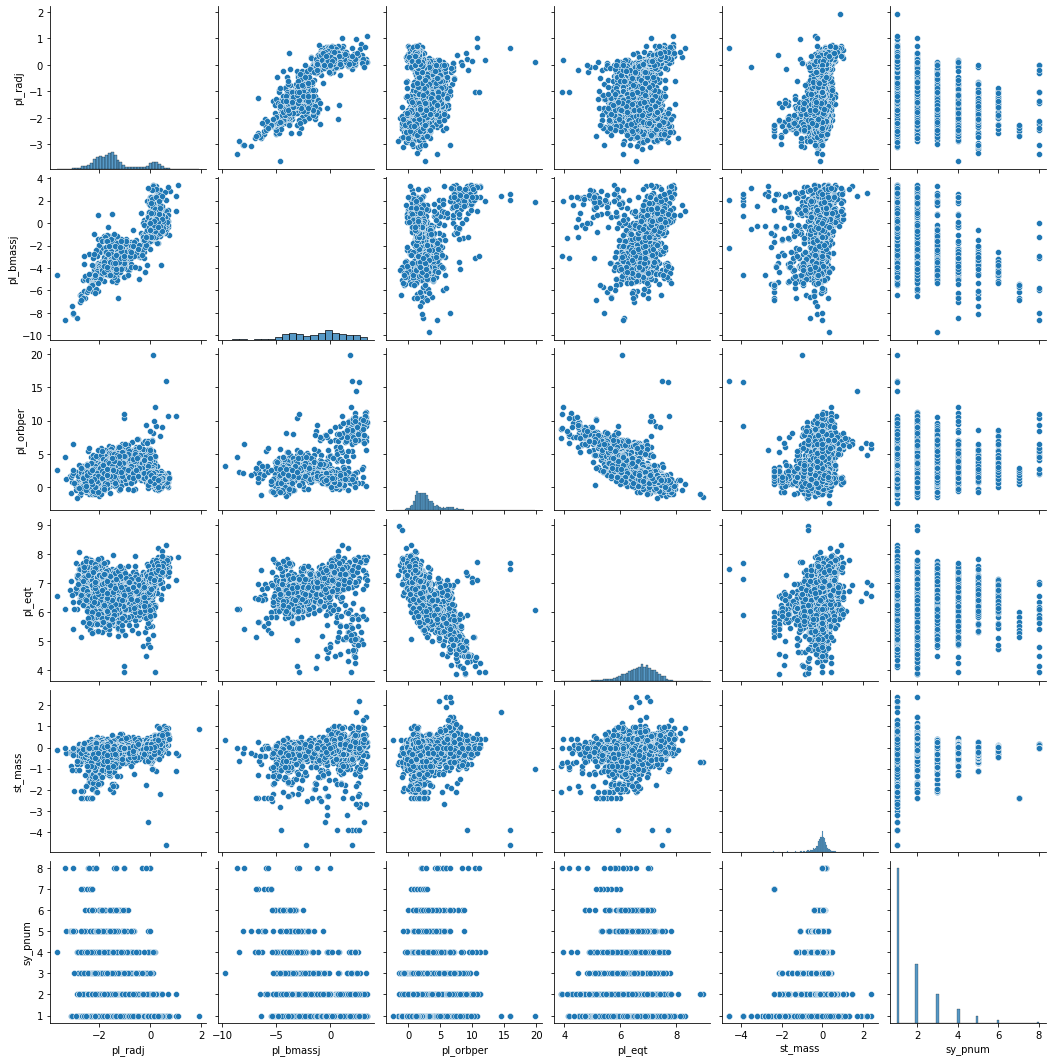

In [9]:
X_df = pd.DataFrame(X, columns=TLG2020_FEATURES)
plt.figure()
sns.pairplot(X_df)
plt.show()

## A. Transit Case

In [10]:
DICT_OBSERVED_MASS_NAME_ID = dict()  # store the name and row number of planets with observed mass
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASSES = len(DICT_OBSERVED_MASS_NAME_ID)

In [8]:
MY_TAU = 1.0 / 50.0  # for kNNxKDE
MY_NB_NEIGH = 20  # for kNNxKDE
MY_NB_NEIGHBORS = 15
MY_NB_TREES = 20
MY_NB_ITERS = 2500

In [9]:
imputed_masses = {
    'knnxkde': dict(),
    'knnimputer': dict(),
    'missforest': dict(),
    'gain': dict(),
    'mice': dict(),
}

N, D = X.shape

NameError: name 'X' is not defined

In [12]:
for i1, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    print(f'{i1+1}/{NB_OBSERVED_MASSES}... {cur_name}                      ', end='\r')
    if ((i1+1)%100)==0:
        print(f'                                           ', end='\r')
        print(f'{i1+1}/{NB_OBSERVED_MASSES} -> {time.strftime("%H:%M:%S", time.localtime())}')
    miss_data = np.copy(X)
    miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
    norm_miss_data, norm_params = normalization(miss_data)
    
    knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
    norm_imputed_data = knnxkde.impute_mean(norm_miss_data, nb_draws=1000)
    renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
    imputed_masses['knnxkde'][cur_name] = np.exp(renorm_imputed_data[cur_idx, 1])
    
    knnimputer = KNNImputer(n_neighbors=MY_NB_NEIGHBORS)
    norm_imputed_data = knnimputer.fit_transform(norm_miss_data)
    renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
    imputed_masses['knnimputer'][cur_name] = np.exp(renorm_imputed_data[cur_idx, 1])
    
    estimator = ExtraTreesRegressor(n_estimators=MY_NB_TREES)
    missforest = IterativeImputer(estimator=estimator, max_iter=10, tol=2e-1, verbose=0)
    norm_imputed_data = missforest.fit_transform(norm_miss_data)
    renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
    imputed_masses['missforest'][cur_name] = np.exp(renorm_imputed_data[cur_idx, 1])
    
    gain_parameters = {'batch_size': 128, 'hint_rate': 0.9, 'alpha': 100, 'iterations': MY_NB_ITERS}
    norm_imputed_data = gain(norm_miss_data, gain_parameters)
    renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
    imputed_masses['gain'][cur_name] = np.exp(renorm_imputed_data[cur_idx, 1])
    
    mice = IterativeImputer(estimator=BayesianRidge(), max_iter=10, tol=2e-1, verbose=0)
    norm_imputed_data = mice.fit_transform(norm_miss_data)
    renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
    imputed_masses['mice'][cur_name] = np.exp(renorm_imputed_data[cur_idx, 1])

100/1426 -> 11:37:31                                        
200/1426 -> 11:41:35                         
300/1426 -> 11:45:30                           
400/1426 -> 11:49:29                           
500/1426 -> 11:53:32                            
600/1426 -> 11:57:26                                  
700/1426 -> 12:01:19                           
800/1426 -> 12:05:13                          
900/1426 -> 12:09:07                          
1000/1426 -> 12:13:02                                    
1100/1426 -> 12:16:57                                      
1200/1426 -> 12:20:52                          
1300/1426 -> 12:24:50                                       
1400/1426 -> 12:28:45                                           


In [16]:
save_dir = f'results_and_figures/2_comp_whole_archive'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
#with open(f'{save_dir}/transit_case_masses.pkl', 'wb') as f:
#    pickle.dump(imputed_masses, f)

Reload the imputed masses, compute error $\epsilon$, and plot results

In [12]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/transit_case_masses.pkl', 'rb') as f:
    imputed_masses = pickle.load(f)

In [13]:
np_masses = np.zeros((7, NB_OBSERVED_MASSES))
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    np_masses[0, i] = imputed_masses['knnxkde'][cur_name]
    np_masses[1, i] = imputed_masses['knnimputer'][cur_name]
    np_masses[2, i] = imputed_masses['missforest'][cur_name]
    np_masses[3, i] = imputed_masses['gain'][cur_name]
    np_masses[4, i] = imputed_masses['mice'][cur_name]
    np_masses[5, i] = chen_kipping_2017_mass(my_df.iloc[cur_idx]['pl_radj'])

In [14]:
np_eps = np.zeros((6, NB_OBSERVED_MASSES))
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    true_mass = my_df.iloc[cur_idx]['pl_bmassj']
    np_eps[0, i] = np.log(true_mass) - np.log(imputed_masses['knnxkde'][cur_name])
    np_eps[1, i] = np.log(true_mass) - np.log(imputed_masses['knnimputer'][cur_name])
    np_eps[2, i] = np.log(true_mass) - np.log(imputed_masses['missforest'][cur_name])
    np_eps[3, i] = np.log(true_mass) - np.log(imputed_masses['gain'][cur_name])
    np_eps[4, i] = np.log(true_mass) - np.log(imputed_masses['mice'][cur_name])
    np_eps[5, i] = np.log(true_mass) - np.log(chen_kipping_2017_mass(my_df.iloc[cur_idx]['pl_radj']))
    np_masses[6, i] = true_mass

In [15]:
print(np.sqrt(np.mean(np_eps ** 2.0, axis=1)))

[1.51015026 1.62793709 1.7009926  2.5516174  1.72792969        nan]


Compute the epsilon over 10 bins (for better insight)

In [16]:
MJ = 317.8  # in Earth masses
list_thresh = np.geomspace(1e-1, 1e4, num=11)
np_eps_thresh = np.zeros(len(list_thresh)-1)

for n in range(len(list_thresh)-1):
    thresh1 = list_thresh[n]
    thresh2 = list_thresh[n+1]
    mask1 = (np_masses[6] * MJ) > thresh1
    mask2 = (np_masses[6] * MJ) < thresh2
    mask = np.logical_and(mask1, mask2)
    print(f"{n} -> {thresh1:.2e} ~ {thresh2:.2e} | Count = {str(np.sum(mask)).rjust(3, ' ')}", end='')
    np_eps_thresh[n] = np.sqrt(np.mean((np.log(np_masses[6]) - np.log(np_masses[0]))[mask] ** 2.0))
    print(f'  => Eps = {np_eps_thresh[n]:.4f}')
print(f'Everyone | Count = {np_masses[6].shape[0]}', end='')
print(f'  => {np.sqrt(np.mean((np.log(np_masses[6]) - np.log(np_masses[0])) ** 2.0)):.4f}')

0 -> 1.00e-01 ~ 3.16e-01 | Count =   3  => Eps = 1.4037
1 -> 3.16e-01 ~ 1.00e+00 | Count =  17  => Eps = 1.8017
2 -> 1.00e+00 ~ 3.16e+00 | Count =  58  => Eps = 1.2015
3 -> 3.16e+00 ~ 1.00e+01 | Count = 207  => Eps = 1.0389
4 -> 1.00e+01 ~ 3.16e+01 | Count = 186  => Eps = 0.7804
5 -> 3.16e+01 ~ 1.00e+02 | Count = 138  => Eps = 1.3787
6 -> 1.00e+02 ~ 3.16e+02 | Count = 297  => Eps = 1.1064
7 -> 3.16e+02 ~ 1.00e+03 | Count = 243  => Eps = 1.2701
8 -> 1.00e+03 ~ 3.16e+03 | Count = 160  => Eps = 2.2127
9 -> 3.16e+03 ~ 1.00e+04 | Count = 113  => Eps = 2.8347
Everyone | Count = 1426  => 1.5102


Obtain the planets in the test set of TLG2020 for comparison.  
Then plot the results like before

In [14]:
rv_dists = np.load('data/mdists__mask[001111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')
transit_dists = np.load('data/mdists__mask[101111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')

In [15]:
colnames = ['idx', 'pl_name', 'pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']
all_planets = pd.read_csv('data/NEA_radmasstpersmasspnum.csv', names=colnames, sep=',', skiprows=1)
rs = np.random.RandomState(12345)
dataidx = rs.permutation(all_planets.shape[0])  # it's the very same, I have checked
train_names = all_planets['pl_name'][dataidx[0:400]]
test_names = all_planets['pl_name'][dataidx[400:]]
true_masses_550 = np.array(all_planets.iloc[dataidx[400:]]['pl_bmassj'])
true_radii_550 = np.array(all_planets.iloc[dataidx[400:]]['pl_radj'])

In [19]:
bins = 500  # Reproduce TLG2020 epsilon results
logbins = np.logspace(np.log10(0.0001), np.log10(100.0), num=bins)  # in M_J

tnet_mass = []
for p in range(transit_dists.shape[0]):
    r = np.histogram(transit_dists[p, :, 1], bins=logbins, density=False)
    xv = (r[1][:-1] + r[1][1:]) / 2.0
    tnet_mass.append(xv[np.argmax(r[0])])
transit_masses_tlg2020 = np.array(tnet_mass)

In [20]:
mask_tlg2020 = np.zeros(NB_OBSERVED_MASSES, dtype='bool')
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    if cur_name in list(test_names):
        mask_tlg2020[i] = True

In [21]:
np_eps_tlg2020 = np.zeros((7, 150))
for i, pl_name in enumerate(test_names):
    if pl_name in DICT_OBSERVED_MASS_NAME_ID:
        cur_idx = DICT_OBSERVED_MASS_NAME_ID[pl_name]
        true_mass = my_df.iloc[cur_idx]['pl_bmassj']
        np_eps_tlg2020[0, i] = np.log(true_mass) - np.log(imputed_masses['knnxkde'][pl_name])
        np_eps_tlg2020[1, i] = np.log(true_mass) - np.log(imputed_masses['knnimputer'][pl_name])
        np_eps_tlg2020[2, i] = np.log(true_mass) - np.log(imputed_masses['missforest'][pl_name])
        np_eps_tlg2020[3, i] = np.log(true_mass) - np.log(imputed_masses['gain'][pl_name])
        np_eps_tlg2020[4, i] = np.log(true_mass) - np.log(imputed_masses['mice'][pl_name])
        np_eps_tlg2020[5, i] = np.log(true_mass) - np.log(chen_kipping_2017_mass(my_df.iloc[cur_idx]['pl_radj']))
        np_eps_tlg2020[6, i] = np.log(true_mass) - np.log(transit_masses_tlg2020[i])
    else:  # 4 planets were in the dataset of TLG2020 but not in the new dataset
        print(pl_name)
        np_eps_tlg2020[:, i] = np.nan

KOI-55 c
K2-239 d
K2-240 b
2MASS J21402931+1625183 A b


In [22]:
print(np.sqrt(np.nanmean(np_eps_tlg2020 ** 2.0, axis=1)))

[0.84632894 1.25845845 0.83508142 1.94191191 0.91760096 3.09352523
 0.92769176]


In [27]:
my_fancy_labels = [
    '$k$NN$\\times$KDE',
    '$k$NN-Imputer',
    'MissForest',
    'GAIN',
    'MICE',
    'PS-CP est.',
]

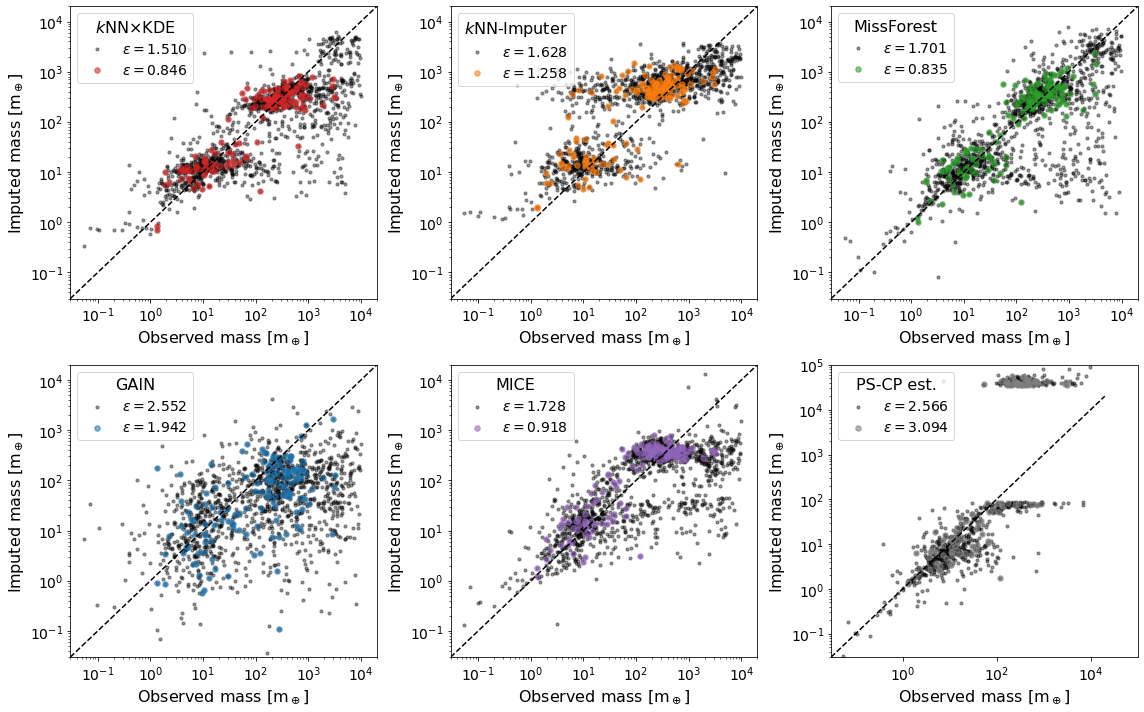

In [28]:
MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(2, 3, figsize=(16, 10))

for i1 in range(2):
    for i2 in range(3):
        my_color = ['C3', 'C1', 'C2', 'C0', 'C4', 'grey'][i1*3+i2]
        cur_eps1 = np.sqrt(np.nanmean(np_eps ** 2.0, axis=1))[i1*3+i2]
        cur_eps2 = np.sqrt(np.nanmean(np_eps_tlg2020 ** 2.0, axis=1))[i1*3+i2]
        my_lab1 = f'$\epsilon=${cur_eps1:.3f}'
        my_lab2 = f'$\epsilon=${cur_eps2:.3f}'
        my_lab_title = my_fancy_labels[i1*3+i2]

        ax[i1][i2].scatter(
            np_masses[6]*MJ,
            np_masses[i1*3+i2]*MJ,
            c='black', s=10, alpha=0.4, label=my_lab1,
        )
        ax[i1][i2].scatter(
            np_masses[6][mask_tlg2020]*MJ,
            np_masses[i1*3+i2][mask_tlg2020]*MJ,
            c=my_color, s=30, alpha=0.6, label=my_lab2,
        )

        ax[i1][i2].set_xscale('log')
        ax[i1][i2].set_yscale('log')
        ax[i1][i2].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
        ax[i1][i2].set_xlabel('Observed mass [m$_\oplus$]', size=16)
        ax[i1][i2].set_ylabel('Imputed mass [m$_\oplus$]', size=16)
        ax[i1][i2].tick_params(axis='both', which='major', labelsize=14)
        ax[i1][i2].set_xlim(MIN_MASS, MAX_MASS)
        ax[i1][i2].set_ylim(MIN_MASS, MAX_MASS)
        ax[i1][i2].legend(fontsize=14, loc='upper left', title=my_lab_title, title_fontsize=16)

ax[1][2].set_xlim(3e-2, 1e5)
ax[1][2].set_ylim(3e-2, 1e5)
#ax[1][2].legend(fontsize=14, loc='lower right', title=my_lab_title, title_fontsize=16)

plt.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/transit_case6.pdf')
plt.show()

Select interesting cases...

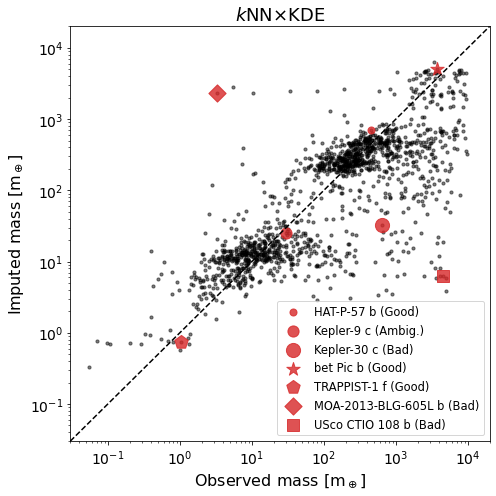

In [80]:
MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(np_masses[6]*MJ, np_masses[0]*MJ, c='black', s=10, alpha=0.5)

idx1, idx2, idx3 = 144, 881, 713  # HAT-P-57 b (GOOD), Kepler-9 c (AMBIGUOUS), Kepler-30 c (BAD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx3]
ax.scatter(np_masses[6][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', s=50, alpha=0.8, label=label1+' (Good)')
ax.scatter(np_masses[6][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', s=125, alpha=0.8, label=label2+' (Ambig.)')
ax.scatter(np_masses[6][idx3]*MJ, np_masses[0][idx3]*MJ, c='C3', s=200, alpha=0.8, label=label3+' (Bad)')

idx1, idx2 = 1411, 1211  # bet Pic b, TRAPPIST-1 f (NEW GOOD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
ax.scatter(np_masses[6][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', marker='*', s=200, alpha=0.8, label=label1+' (Good)')
ax.scatter(np_masses[6][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', marker='p', s=200, alpha=0.8, label=label2+' (Good)')

idx1, idx2 = 929, 1222  # MOA-2013-BLG-605L b, USco CTIO 108 b (NEW BAD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
ax.scatter(np_masses[6][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', marker='D', s=150, alpha=0.8, label=label1+' (Bad)')
ax.scatter(np_masses[6][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', marker='s', s=150, alpha=0.8, label=label2+' (Bad)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax.set_xlabel('Observed mass [m$_\oplus$]', size=16)
ax.set_ylabel('Imputed mass [m$_\oplus$]', size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(MIN_MASS, MAX_MASS)
ax.set_ylim(MIN_MASS, MAX_MASS)
ax.legend(fontsize=11.5, loc='lower right')
ax.set_title('$k$NN$\\times$KDE', size=18)

plt.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/transit_case_knnxkde3.pdf')
plt.show()

Locate lensed planets...  
-> Yes, their mass is poorly predicted

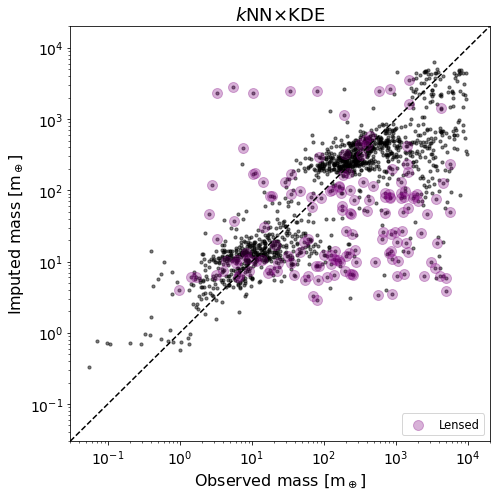

In [26]:
mask = np.zeros(len(DICT_OBSERVED_MASS_NAME_ID), dtype=bool)
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    if cur_name[:3]=='KMT' or cur_name[:3]=='MOA' or cur_name[:4]=='OGLE':
        mask[i] = True

MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(np_masses[6]*MJ, np_masses[0]*MJ, c='black', s=10, alpha=0.5)
ax.scatter(np_masses[6][mask]*MJ, np_masses[0][mask]*MJ, c='purple', s=100, alpha=0.3, label='Lensed')

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax.set_xlabel('Observed mass [m$_\oplus$]', size=16)
ax.set_ylabel('Imputed mass [m$_\oplus$]', size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(MIN_MASS, MAX_MASS)
ax.set_ylim(MIN_MASS, MAX_MASS)
ax.legend(fontsize=11.5, loc='lower right')
ax.set_title('$k$NN$\\times$KDE', size=18)

plt.tight_layout()
#plt.savefig('results_and_figures/2_comp_whole_archive/transit_case_knnxkde3.pdf')
plt.show()

In [37]:
np.sqrt(np.mean(np_eps[0][mask] ** 2.0))

2.8895933556544406

Quantify improvement from the TLG2020 dataset to this new bigger dataset.  
-> Improvement seems to lie in sparser areas. Which is where the full archive is the most helpful.

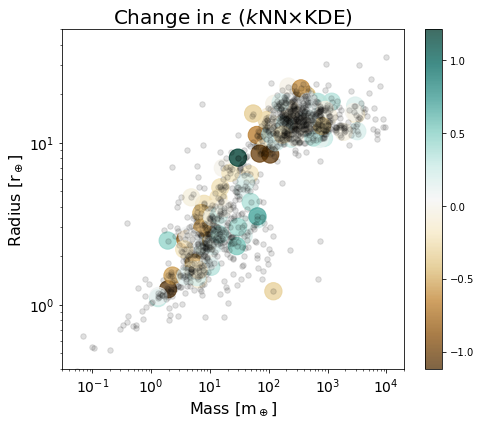

In [79]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
MIN_RAD, MAX_RAD = 4e-1, 5e1
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

s = ax.scatter(true_masses[mask_tlg2020]*MJ, true_radii[mask_tlg2020]*RJ, c=my_colors[mask_tlg2020], s=300, alpha=0.75, cmap='BrBG')
ax.scatter(true_masses*MJ, true_radii*RJ, c='black', s=30, alpha=0.12)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mass [m$_\oplus$]', size=16)
ax.set_ylabel('Radius [r$_\oplus$]', size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(MIN_MASS, MAX_MASS)
ax.set_ylim(MIN_RAD, MAX_RAD)
ax.set_title('Change in $\epsilon$ ($k$NN$\\times$KDE)', size=20)
fig.colorbar(s)

fig.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/transit_case_compare_knnxkde2.pdf')
plt.show()

## B. RV Case

In [10]:
DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID = dict()  # name and row id for planets with observed mass AND radius
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]) and ~np.isnan(my_df['pl_radj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASS_AND_RADIUS = len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID)

In [11]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
imputed_samples = dict()  # will store imputation sample for each planet
N, D = X.shape

In [10]:
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    print(f'{i+1}/{NB_OBSERVED_MASS_AND_RADIUS}... {cur_name}                      ', end='\r')
    if ((i+1)%100)==0:
        print(f'                                           ', end='\r')
        print(f'{i+1}/{NB_OBSERVED_MASS_AND_RADIUS} -> {time.strftime("%H:%M:%S", time.localtime())}')
    miss_data = np.copy(X)
    miss_data[cur_idx, 0] = np.nan  # RV case: hide the radius...
    miss_data[cur_idx, 1] = np.nan  # ... and the mass
    norm_miss_data, norm_params = normalization(miss_data)
    r1 = norm_params['min_val'][0]
    r2 = norm_params['max_val'][0]
    m1 = norm_params['min_val'][1]
    m2 = norm_params['max_val'][1]

    knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
    norm_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)
    imputed_samples[(cur_name, 'radius')] = norm_samples[(cur_idx, 0)] * (r2 + 1e-6) + r1
    imputed_samples[(cur_name, 'mass')] = norm_samples[(cur_idx, 1)] * (m2 + 1e-6) + m1

100/1081 -> 16:45:38                                     
200/1081 -> 17:03:39                         
300/1081 -> 17:21:39                           
400/1081 -> 17:39:41                          
500/1081 -> 17:57:44                           
600/1081 -> 18:15:45                          
700/1081 -> 18:33:46                          
800/1081 -> 18:51:47                             
900/1081 -> 19:10:01                              
1000/1081 -> 19:28:03                         


In [11]:
save_dir = f'results_and_figures/2_comp_whole_archive'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
#with open(f'{save_dir}/rv_case_masses_radii.pkl', 'wb') as f:
#    pickle.dump(imputed_samples, f)

Save the samples...  
Reload them for analysis + plotting  
1. Raw results
2. With convolution

In [16]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/rv_case_masses_radii.pkl', 'rb') as f:
    imputed_samples = pickle.load(f)  # Note: samples are in log

In [17]:
epsilons = np.zeros((2, NB_OBSERVED_MASS_AND_RADIUS))  # radius and mass
mask_tlg2020 = np.zeros(NB_OBSERVED_MASS_AND_RADIUS, dtype='bool')
list_true_estimate = np.zeros((2, 2, NB_OBSERVED_MASS_AND_RADIUS))  # radius and mass

for i1, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    true_radius = my_df.iloc[cur_idx]['pl_radj']
    true_mass = my_df.iloc[cur_idx]['pl_bmassj']
    list_true_estimate[0, 0, i1] = true_radius
    list_true_estimate[1, 0, i1] = true_mass
    if cur_name in list(test_names):
        mask_tlg2020[i1] = True
    rad_estimate = np.exp(np.mean(imputed_samples[(cur_name, 'radius')]))
    list_true_estimate[0, 1, i1] = rad_estimate
    epsilons[0, i1] = np.log(rad_estimate) - np.log(true_radius)
    mass_estimate = np.exp(np.mean(imputed_samples[(cur_name, 'mass')]))
    list_true_estimate[1, 1, i1] = mass_estimate
    epsilons[1, i1] = np.log(mass_estimate) - np.log(true_mass)

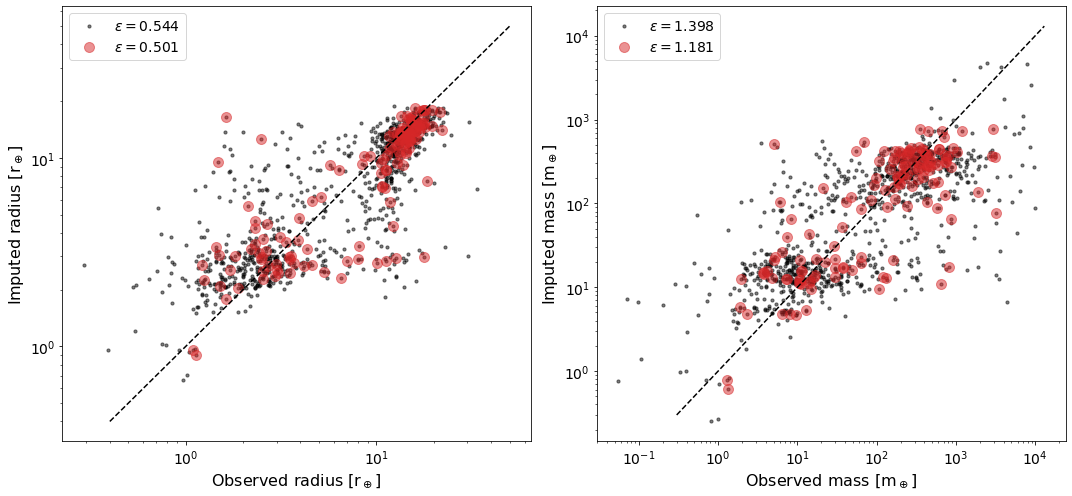

In [38]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
MIN_RAD, MAX_RAD = 4e-1, 5e1
MIN_MASS, MAX_MASS = 3e-1, 1.3e4

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

for i in range(2):
    cur_eps1 = np.sqrt(np.mean(epsilons[i]**2.0))
    cur_eps2 = np.sqrt(np.mean(epsilons[i][mask_tlg2020]**2.0))
    my_lab1 = f'$\epsilon=${cur_eps1:.3f}'
    my_lab2 = f'$\epsilon=${cur_eps2:.3f}'
    
    ax[i].scatter(
        list_true_estimate[i, 0]*[RJ, MJ][i],
        list_true_estimate[i, 1]*[RJ, MJ][i],
        c='black', s=10, alpha=0.5, label=my_lab1,
    )
    ax[i].scatter(
        list_true_estimate[i, 0][mask_tlg2020]*[RJ, MJ][i],
        list_true_estimate[i, 1][mask_tlg2020]*[RJ, MJ][i],
        c='C3', s=100, alpha=0.5, label=my_lab2,
    )
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].legend(fontsize=14, loc='upper left', title_fontsize=16)

ax[0].plot([MIN_RAD, MAX_RAD], [MIN_RAD, MAX_RAD], 'k--')
ax[0].set_xlabel('Observed radius [r$_\oplus$]', size=16)
ax[0].set_ylabel('Imputed radius [r$_\oplus$]', size=16)
ax[1].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax[1].set_xlabel('Observed mass [m$_\oplus$]', size=16)
ax[1].set_ylabel('Imputed mass [m$_\oplus$]', size=16)

plt.tight_layout()
#plt.savefig('results_and_figures/whole_archive/rv_case.pdf')
plt.show()

In [18]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

rad_distrib_numpy = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_numpy = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
true_radii_numpy = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
true_masses_numpy = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
mask_tlg2020 = np.zeros(NB_OBSERVED_MASS_AND_RADIUS, dtype='bool')

for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    rad_distrib_numpy[i] = np.exp(imputed_samples[(cur_name, 'radius')])
    mass_distrib_numpy[i] = np.exp(imputed_samples[(cur_name, 'mass')])
    true_radii_numpy[i] = my_df.iloc[cur_idx]['pl_radj']
    true_masses_numpy[i] = my_df.iloc[cur_idx]['pl_bmassj']
    if cur_name in list(test_names):
        mask_tlg2020[i] = True

In [19]:
np.random.seed(666)  # For reproducibility
nb_repeat = 100

rad_estimates = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    rad_estimates[:, n], mass_estimates[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_numpy,
        mass_distrib=mass_distrib_numpy,
        true_masses=true_masses_numpy,
        incl=cur_i,
    )

In [21]:
rad_imputed_values = np.mean(rad_estimates, axis=-1)
mass_imputed_values = np.mean(mass_estimates, axis=-1)

rad_eps1 = np.sqrt(np.mean((np.log(rad_imputed_values) - np.log(true_radii_numpy)) ** 2.0))
rad_eps2 = np.sqrt(np.mean((np.log(rad_imputed_values[mask_tlg2020]) - np.log(true_radii_numpy[mask_tlg2020])) ** 2.0))
mass_eps1 = np.sqrt(np.mean((np.log(mass_imputed_values) - np.log(true_masses_numpy)) ** 2.0))
mass_eps2 = np.sqrt(np.mean((np.log(mass_imputed_values[mask_tlg2020]) - np.log(true_masses_numpy[mask_tlg2020])) ** 2.0))

print(f'Radius ==> Epsilon 1 = {rad_eps1:.4f} | Epsilon 2 = {rad_eps2:.4f}')
print(f'Mass ==> Epsilon 1 = {mass_eps1:.4f} | Epsilon 2 = {mass_eps2:.4f}')

Radius ==> Epsilon 1 = 0.3980 | Epsilon 2 = 0.4056
Mass ==> Epsilon 1 = 0.1806 | Epsilon 2 = 0.2411


Compute the epsilon over 10 bins

In [78]:
list_thresh = np.geomspace(1e-1, 1e4, num=11)
np_eps_thresh = np.zeros(len(list_thresh)-1)

for n in range(len(list_thresh)-1):
    thresh1 = list_thresh[n]
    thresh2 = list_thresh[n+1]
    mask1 = (true_masses_numpy * MJ) > thresh1
    mask2 = (true_masses_numpy * MJ) < thresh2
    mask = np.logical_and(mask1, mask2)
    print(f"{n} -> {thresh1:.2e} ~ {thresh2:.2e} | Count = {str(np.sum(mask)).rjust(3, ' ')}", end='')
    np_eps_thresh[n] = np.sqrt(np.mean((np.log(true_masses_numpy) - np.log(mass_imputed_values))[mask] ** 2.0))
    print(f'  => Eps = {np_eps_thresh[n]:.4f}')
print(f'Everyone | Count = {true_masses_numpy.shape[0]}', end='')
print(f'  => {np.sqrt(np.mean((np.log(true_masses_numpy) - np.log(mass_imputed_values)) ** 2.0)):.4f}')

0 -> 1.00e-01 ~ 3.16e-01 | Count =   3  => Eps = 0.2777
1 -> 3.16e-01 ~ 1.00e+00 | Count =  15  => Eps = 0.2805
2 -> 1.00e+00 ~ 3.16e+00 | Count =  54  => Eps = 0.1154
3 -> 3.16e+00 ~ 1.00e+01 | Count = 187  => Eps = 0.3418
4 -> 1.00e+01 ~ 3.16e+01 | Count = 164  => Eps = 0.2016
5 -> 3.16e+01 ~ 1.00e+02 | Count = 113  => Eps = 0.0946
6 -> 1.00e+02 ~ 3.16e+02 | Count = 251  => Eps = 0.0482
7 -> 3.16e+02 ~ 1.00e+03 | Count = 205  => Eps = 0.0669
8 -> 1.00e+03 ~ 3.16e+03 | Count =  61  => Eps = 0.1051
9 -> 3.16e+03 ~ 1.00e+04 | Count =  25  => Eps = 0.1730
Everyone | Count = 1081  => 0.1806


Now plot

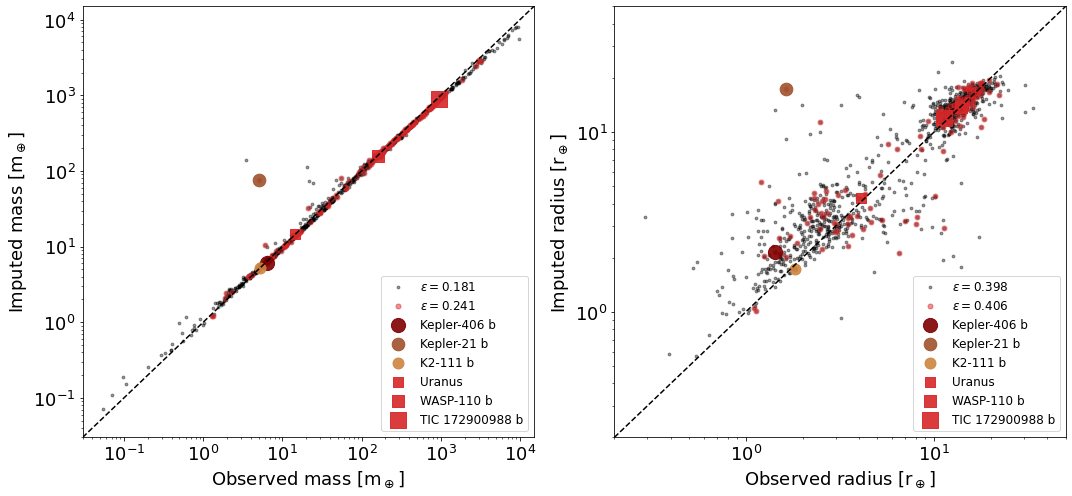

In [25]:
MIN_RAD, MAX_RAD = 2e-1, 5e1  # 4e-1, 5e1
MIN_MASS, MAX_MASS = 3e-2, 1.5e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
lab_rad1 = f'$\epsilon=${rad_eps1:.3f}'
lab_rad2 = f'$\epsilon=${rad_eps2:.3f}'
lab_mass1 = f'$\epsilon=${mass_eps1:.3f}'
lab_mass2 = f'$\epsilon=${mass_eps2:.3f}'
ax[0].scatter(true_masses_numpy*MJ, mass_imputed_values*MJ, c='black', s=8, alpha=0.4, label=lab_mass1)
ax[0].scatter(true_masses_numpy[mask_tlg2020]*MJ, mass_imputed_values[mask_tlg2020]*MJ, c='C3', s=25, alpha=0.5, label=lab_mass2)
ax[1].scatter(true_radii_numpy*RJ, rad_imputed_values*RJ, c='black', s=8, alpha=0.4, label=lab_rad1)
ax[1].scatter(true_radii_numpy[mask_tlg2020]*RJ, rad_imputed_values[mask_tlg2020]*RJ, c='C3', s=25, alpha=0.5, label=lab_rad2)

idx1, idx2, idx3 = 567, 463, 279  # Kepler-406 b (still GOOD), Kepler-21 b (still BAD), K2-111 b (BAD before, now GOOD)
label1 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx3]
ax[0].scatter(true_masses_numpy[idx1]*MJ, mass_imputed_values[idx1]*MJ, c='maroon', s=200, alpha=0.9, label=label1)
ax[0].scatter(true_masses_numpy[idx2]*MJ, mass_imputed_values[idx2]*MJ, c='sienna', s=160, alpha=0.9, label=label2)
ax[0].scatter(true_masses_numpy[idx3]*MJ, mass_imputed_values[idx3]*MJ, c='peru', s=120, alpha=0.9, label=label3)
ax[1].scatter(true_radii_numpy[idx1]*RJ, rad_imputed_values[idx1]*RJ, c='maroon', s=200, alpha=0.9, label=label1)
ax[1].scatter(true_radii_numpy[idx2]*RJ, rad_imputed_values[idx2]*RJ, c='sienna', s=160, alpha=0.9, label=label2)
ax[1].scatter(true_radii_numpy[idx3]*RJ, rad_imputed_values[idx3]*RJ, c='peru', s=120, alpha=0.9, label=label3)

idx1, idx2, idx3 = 1079, 904, 745  # Uranus, WASP-110 b, TIC 172900988 b
label1 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx1]
label1 = 'Uranus'
label2 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx3]
ax[0].scatter(true_masses_numpy[idx1]*MJ, mass_imputed_values[idx1]*MJ, c='C3', s=100, marker='s', alpha=0.9, label=label1)
ax[0].scatter(true_masses_numpy[idx2]*MJ, mass_imputed_values[idx2]*MJ, c='C3', s=150, marker='s', alpha=0.9, label=label2)
ax[0].scatter(true_masses_numpy[idx3]*MJ, mass_imputed_values[idx3]*MJ, c='C3', s=250, marker='s', alpha=0.9, label=label3)
ax[1].scatter(true_radii_numpy[idx1]*RJ, rad_imputed_values[idx1]*RJ, c='C3', s=100, marker='s', alpha=0.9, label=label1)
ax[1].scatter(true_radii_numpy[idx2]*RJ, rad_imputed_values[idx2]*RJ, c='C3', s=150, marker='s', alpha=0.9, label=label2)
ax[1].scatter(true_radii_numpy[idx3]*RJ, rad_imputed_values[idx3]*RJ, c='C3', s=250, marker='s', alpha=0.9, label=label3)

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='both', which='major', labelsize=18)
    ax[i].legend(fontsize=12, loc='lower right')
ax[0].set_xlabel('Observed mass [m$_\oplus$]', size=18)
ax[0].set_ylabel('Imputed mass [m$_\oplus$]', size=18)
ax[0].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax[0].set_xlim(MIN_MASS, MAX_MASS)
ax[0].set_ylim(MIN_MASS, MAX_MASS)
ax[1].set_xlabel('Observed radius [r$_\oplus$]', size=18)
ax[1].set_ylabel('Imputed radius [r$_\oplus$]', size=18)
ax[1].plot([MIN_RAD, MAX_RAD], [MIN_RAD, MAX_RAD], 'k--')
ax[1].set_xlim(MIN_RAD, MAX_RAD)
ax[1].set_ylim(MIN_RAD, MAX_RAD)

fig.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/rv_convolutionNEW.pdf')
plt.show()

Show in example of a bi-variate distribution for radius-mass (GJ 1252 b).  
We can clearly see three groups compatible with the observed other properties.

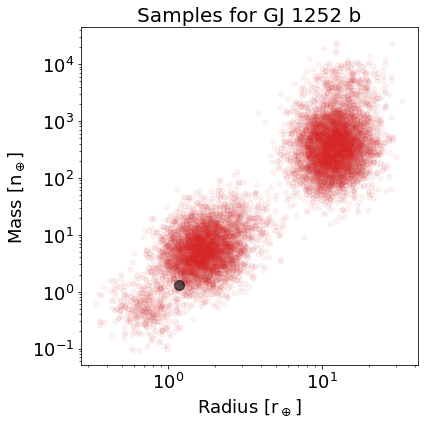

In [270]:
idx = 51
label = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(rad_distrib_numpy[idx]*RJ, mass_distrib_numpy[idx]*MJ, s=25, c='C3', alpha=0.05)
ax.scatter(true_radii_numpy[idx]*RJ, true_masses_numpy[idx]*MJ, s=100, c='black', alpha=0.6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel('Radius [r$_\oplus$]', size=18)
ax.set_ylabel('Mass [n$_\oplus$]', size=18)
ax.set_title(f'Samples for {label}', size=20)

fig.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/example_GJ 1252 b.pdf')
plt.show()